# Initial Assessment: SPY
In this project, we will rerun our base initial assessment workflow on SPY.
However, we will be calling the refactored functions as opposed to writing it inline. 
SPY is the NYSEARCA ticker for the SPDR S&P 500 ETF Trust.
This ETF follows the S&P 500 index with a target price of S&P500*.01 and beta=1.
This workflow uses all historical data to assess simple trend fitting, autocorrelation and
robust statistics for estimating risk and return metrics.
The goal is to identify:
* sample freq;
* sample period;
* deviation event lengths (particularly for re allocation timeframes); and
* expected returns as a function of hold time.


## Setup

In [2]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'
import sys
# adding analytics to the system path
sys.path.insert(0, '/Users/rtasseff/projects/condor_test/analytics')

from data_mining import load

import numpy as np


## I Load SPY data 
We are using the full SPY history (1993-2024), manually downloaded.

<class 'pandas.core.frame.DataFrame'>
Index: 8091 entries, 8090 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         8091 non-null   datetime64[ns]
 1   Open         8091 non-null   object        
 2   High         7964 non-null   float64       
 3   Low          7964 non-null   float64       
 4   Close*       7964 non-null   float64       
 5   Adj Close**  7964 non-null   float64       
 6   Volume       7964 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 505.7+ KB


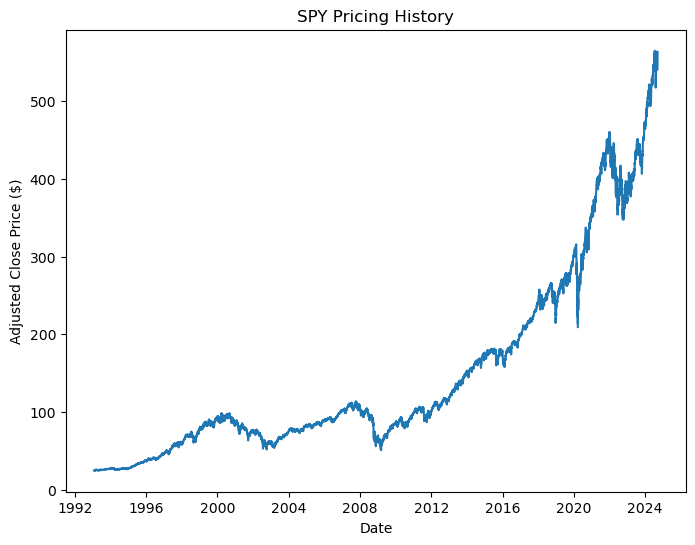

In [3]:


# get data

dates,prices = load.assetHist_CSV(dataDir+'/spy_MAX.tab', sep='\t',assetN='SPY')


## II Identify Trend 
Here we want to identify the overall market trend in the form
of a simple, closed-form analytical equation. 
We considered low order polynomial, exponential and log functions.
We assessed each based on fit and complexity using an information criterion.
Here we will use the Bayesian Information Criteria (BIC) and 
adjusted r-squared value built into the statsmodel library.

We found that polynomials improved both the BIC and 
the adj r-squared value up to order four.
We expect worsening results due to numerical instability at order 5 and higher.
The 4<sup>th</sup> order polynomial captured about 98% of variability.  
This fit was only slightly better than the 3<sup>rd</sup> order.
This was the same fit used in the S&P 500 data.
Interestingly the exponential polynomial did poorly
as compared to great performance on the S&P 500 data. 
However, this is probably due to the truncated time series of the SPY 
(30 vs 50 years).
Pre 2000 tech bubble (and repeal of Glass–Steagall) the market 
was fundamentally different, with much less variability.
This provided a long starting streak in the S&P 500 
that was relatively flat compared to post 2000 behavior.
The exp fit benefited from this time frame on the S&P 500, 
but SPY was not offered until 1993.